# 4. Association Rule Mining (v2 - Advanced)

This notebook implements high-quality association rule mining by filtering for top-rated interactions (Rating >= 4) and exploring complex itemsets (up to 3 categories). This approach avoids 'noise' and provides more accurate product suggestions.

### Objectives:
1. **Clean & Filter**: Focus on high-quality behavior (Rating >= 4).
2. **Advanced Mining**: Find relationships between pairs of categories and a third category (`max_len=3`).
3. **Visualization**: Show data flow and rule distribution.
4. **Professional Export**: Ensure 'smooth' data without infinity values.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import os

# Ensure the working directory is the project root
# This handles cases where the notebook is run from the 'implementation' folder
if os.path.basename(os.getcwd()) == 'implementation':
    os.chdir('..')
    print(f"Changed working directory to: {os.getcwd()}")
else:
    print(f"Current working directory: {os.getcwd()}")

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# File Paths (Now relative to project root)
RATINGS_PATH = 'proceed/new_rating.csv'
PRODUCTS_PATH = 'proceed/Amazon-Products_processed_03.csv'
OUTPUT_PATH = 'association_rules/association_rules_2.csv'

Changed working directory to: d:\e-commerce-dataset


## 4.1 Data Preparation for Transactions

### Loading and Profiling

In [4]:
# Load datasets
ratings_df = pd.read_csv(RATINGS_PATH)
products_df = pd.read_csv(PRODUCTS_PATH)

print("--- Ratings Dataset Info ---")
print(ratings_df.info())
print("\n--- Ratings Descriptions ---")
print(ratings_df.describe())

print("\n--- Products Dataset Info ---")
print(products_df.info())

--- Ratings Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237130 entries, 0 to 237129
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    237130 non-null  int64 
 1   productid  237130 non-null  object
 2   rating     237130 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.4+ MB
None

--- Ratings Descriptions ---
             user_id         rating
count  237130.000000  237130.000000
mean      998.427086       3.871417
std       577.192087       1.017507
min         1.000000       1.000000
25%       499.000000       3.000000
50%       997.000000       4.000000
75%      1498.000000       5.000000
max      2000.000000       5.000000

--- Products Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237130 entries, 0 to 237129
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0  

### Filtering and Transformation

We filter for **Rating >= 4** to ensure we are learning from positive user experiences.

In [5]:
# 1. Select only high-quality ratings
high_quality_ratings = ratings_df[ratings_df['rating'] >= 4]

# 2. Map Categorical Keys (Main - Sub)
products_df['category_key'] = products_df['main_category'] + " - " + products_df['sub_category']

# 3. Merge
merged_df = pd.merge(
    high_quality_ratings, 
    products_df[['id', 'category_key']], 
    left_on='productid', 
    right_on='id', 
    how='inner'
)

# 4. Group by User (Transactions)
transactions = merged_df.groupby('user_id')['category_key'].apply(lambda x: list(set(x))).tolist()

print(f"Original Ratings count: {len(ratings_df)}")
print(f"High quality ratings count (>=4): {len(high_quality_ratings)}")
print(f"Number of transactions generated: {len(transactions)}")

Original Ratings count: 237130
High quality ratings count (>=4): 166283
Number of transactions generated: 2000


### Data Flow Diagram (Conceptual)

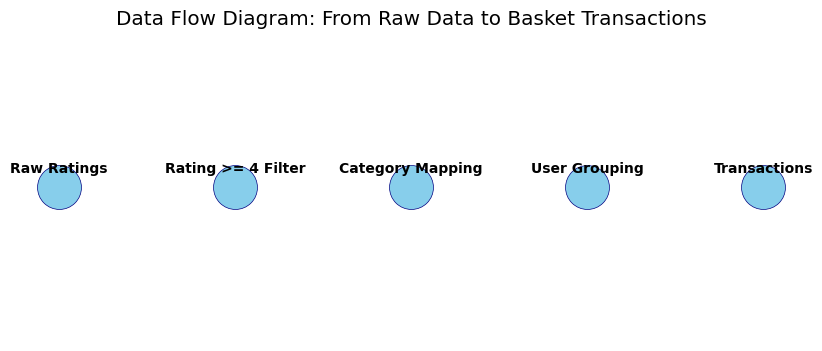

In [6]:
plt.figure(figsize=(10, 4))
steps = ['Raw Ratings', 'Rating >= 4 Filter', 'Category Mapping', 'User Grouping', 'Transactions']
x = np.arange(len(steps))
y = [1] * len(steps)
plt.scatter(x, y, s=1000, c='skyblue', edgecolors='navy')
for i, txt in enumerate(steps):
    plt.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')
plt.title('Data Flow Diagram: From Raw Data to Basket Transactions')
plt.axis('off')
plt.show()

## 4.2 Association Rule Mining (Apriori / FP-Growth)

Using **max_len=3** to find more detailed patterns.

In [7]:
# One-hot encoding
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_ohe = pd.DataFrame(te_ary, columns=te.columns_)

# Mining with max_len=3
# We use a slightly lower support since the data is sparser after filtering
min_support = 0.05
frequent_itemsets = apriori(df_ohe, min_support=min_support, use_colnames=True, max_len=3)
print(f"Frequent itemsets found: {len(frequent_itemsets)}")

Frequent itemsets found: 52576


## 4.3 Rule Evaluation (Support, Confidence, Lift)

Generating rules and cleaning up infinity values.

In [8]:
if not frequent_itemsets.empty:
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
    
    # Standardize column names
    def format_set(s): return ", ".join(list(s))
    
    rules['antecedents_str'] = rules['antecedents'].apply(format_set)
    rules['consequents_str'] = rules['consequents'].apply(format_set)
    
    # Handle Infinity in conviction
    # Formula: (1 - support(B)) / (1 - confidence(A->B)). If confidence is 1.0, use a high cap.
    rules['conviction'] = rules['conviction'].replace([np.inf, -np.inf], 10.0)
    
    # Select columns
    output_df = rules[[
        'antecedents_str', 'consequents_str', 'antecedent support', 
        'consequent support', 'support', 'confidence', 
        'lift', 'leverage', 'conviction'
]].copy()
    
    output_df.rename(columns={'antecedents_str': 'antecedents', 'consequents_str': 'consequents'}, inplace=True)
    
    print(f"Total Rules generated: {len(output_df)}")
    print("\n--- Top 10 Rules by Lift ---")
    print(output_df.sort_values('lift', ascending=False).head(10))
else:
    print("No rules found.")

Total Rules generated: 141202

--- Top 10 Rules by Lift ---
                                             antecedents  \
54515               beauty & health - Household Supplies   
54510  toys & baby products - Toys & Games, appliance...   
77043                toys & baby products - Toys & Games   
77042  men's clothing - Innerwear, beauty & health - ...   
77451                toys & baby products - Toys & Games   
77450  beauty & health - Household Supplies, tv, audi...   
77449  toys & baby products - Toys & Games, tv, audio...   
77452               beauty & health - Household Supplies   
77457                toys & baby products - Toys & Games   
77456  beauty & health - Household Supplies, tv, audi...   

                                             consequents  antecedent support  \
54515  toys & baby products - Toys & Games, appliance...              0.2035   
54510               beauty & health - Household Supplies              0.1965   
77043  men's clothing - Innerwear, beau

### Rule Distribution Plot

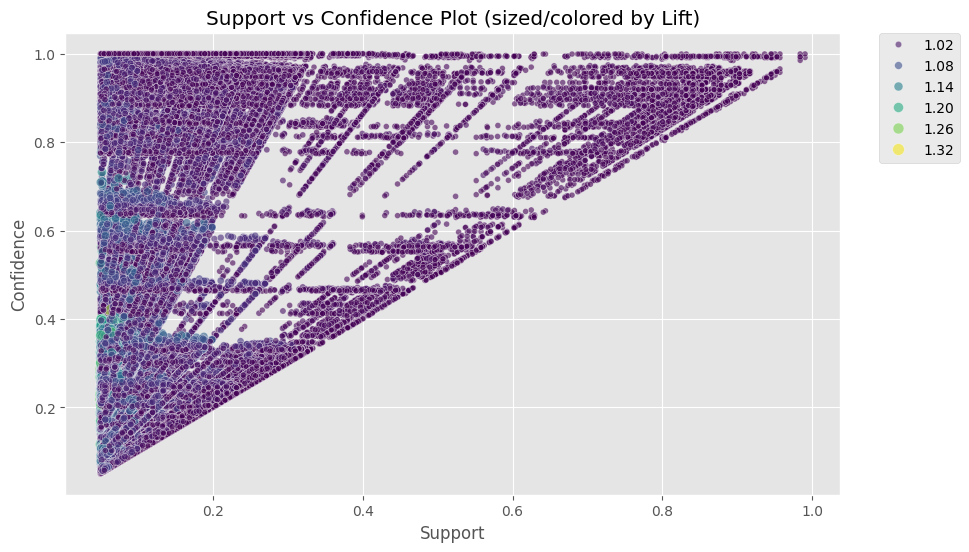

In [9]:
if not frequent_itemsets.empty:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=rules, x='support', y='confidence', size='lift', hue='lift', palette='viridis', alpha=0.6)
    plt.title('Support vs Confidence Plot (sized/colored by Lift)')
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()

## 4.4 Association-based Recommendation Strategy

### Impact Analysis

By using `max_len=3`, we can now recommend products based on combinations of previous interests, we might recommend a specific sub-category that specifically complements both.

### Exporting Results

In [10]:
if not frequent_itemsets.empty:
    if not os.path.exists('association_rules'):
        os.makedirs('association_rules')
    output_df.to_csv(OUTPUT_PATH, index=False)
    print(f"Advanced rules exported successfully to {OUTPUT_PATH}")

Advanced rules exported successfully to association_rules/association_rules_2.csv
